In [53]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import random
import cv2
import seaborn

In [54]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [55]:
word_len = [len(sentence) for sentence in train_data]
print("max len: {} min len: {} mean len: {}".format(max(word_len), min(word_len), sum(word_len) // len(word_len)))

max len: 2494 min len: 11 mean len: 238


In [56]:
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k, v in word_index.items()}

In [57]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

In [58]:
index_word = dict(
    [(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join(
        [index_word.get(word_id, "<UNK>") for word_id in text_ids])

In [59]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [60]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

# print(decode_review(train_data[0]))

In [61]:
embedding_dim = 16
batch_size = 1024

single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length,
                           mask_zero=True),
    keras.layers.SimpleRNN(units = 64, return_sequences = False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics = ['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 64)                5184      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [62]:
earlyStop = keras.callbacks.EarlyStopping(patience=3)
epochs = 20
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.2,
    callbacks = [earlyStop])

Epoch 1/20
20/20 [==============================] - 14s 672ms/step - loss: 0.6938 - accuracy: 0.5144 - val_loss: 0.6903 - val_accuracy: 0.5190
Epoch 2/20
20/20 [==============================] - 13s 633ms/step - loss: 0.6823 - accuracy: 0.5785 - val_loss: 0.6815 - val_accuracy: 0.5846
Epoch 3/20
20/20 [==============================] - 14s 682ms/step - loss: 0.6565 - accuracy: 0.6876 - val_loss: 0.7149 - val_accuracy: 0.4940
Epoch 4/20
20/20 [==============================] - 12s 614ms/step - loss: 0.6836 - accuracy: 0.5603 - val_loss: 0.6848 - val_accuracy: 0.5556
Epoch 5/20
20/20 [==============================] - 12s 618ms/step - loss: 0.6422 - accuracy: 0.6723 - val_loss: 0.6791 - val_accuracy: 0.5678
Epoch 6/20
20/20 [==============================] - 13s 661ms/step - loss: 0.5757 - accuracy: 0.7337 - val_loss: 0.6917 - val_accuracy: 0.5800
Epoch 7/20
20/20 [==============================] - 12s 621ms/step - loss: 0.4502 - accuracy: 0.8100 - val_loss: 0.7154 - val_accuracy: 0.6188

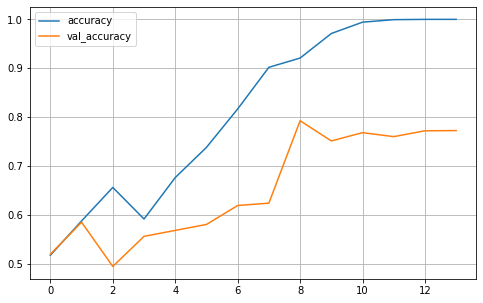

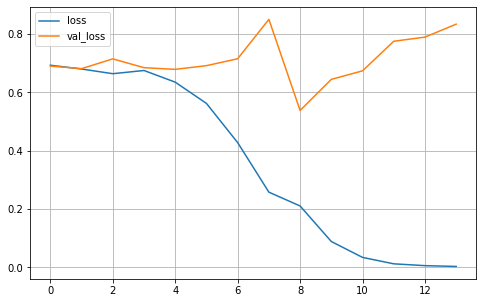

In [63]:
def plot_learning_curves(history, label):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
plot_learning_curves(history_single_rnn, 'accuracy')
plot_learning_curves(history_single_rnn, 'loss')

In [64]:
bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length,
                           mask_zero=True),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                3136      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [65]:
history_bi_rnn = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2,
    callbacks = [earlyStop])

Epoch 1/30
20/20 [==============================] - 26s 1s/step - loss: 0.6936 - accuracy: 0.5136 - val_loss: 0.6899 - val_accuracy: 0.5492
Epoch 2/30
20/20 [==============================] - 23s 1s/step - loss: 0.6767 - accuracy: 0.6244 - val_loss: 0.6216 - val_accuracy: 0.6902
Epoch 3/30
20/20 [==============================] - 23s 1s/step - loss: 0.5808 - accuracy: 0.7242 - val_loss: 0.4771 - val_accuracy: 0.8070
Epoch 4/30
20/20 [==============================] - 23s 1s/step - loss: 0.4120 - accuracy: 0.8401 - val_loss: 0.3669 - val_accuracy: 0.8486
Epoch 5/30
20/20 [==============================] - 24s 1s/step - loss: 0.2863 - accuracy: 0.8899 - val_loss: 0.3350 - val_accuracy: 0.8628
Epoch 6/30
20/20 [==============================] - 22s 1s/step - loss: 0.2171 - accuracy: 0.9206 - val_loss: 0.3259 - val_accuracy: 0.8714
Epoch 7/30
20/20 [==============================] - 23s 1s/step - loss: 0.1581 - accuracy: 0.9469 - val_loss: 0.3302 - val_accuracy: 0.8748
Epoch 8/30
20/20 [==

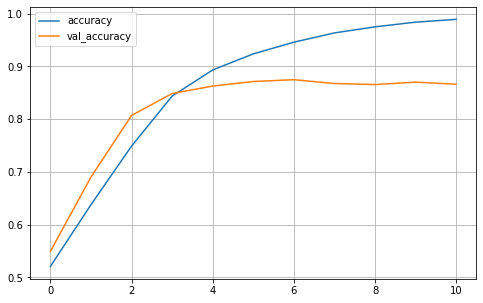

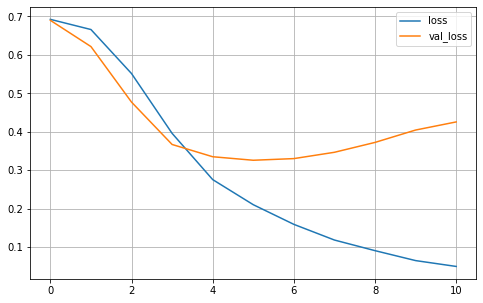

In [66]:
plot_learning_curves(history_bi_rnn, 'accuracy')
plot_learning_curves(history_bi_rnn, 'loss')

In [84]:
bi_rnn_dropout_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length,
                           mask_zero=True),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 32, return_sequences = False)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_dropout_model.summary()
bi_rnn_dropout_model.compile(optimizer = 'adam',
                             loss = 'binary_crossentropy',
                             metrics = ['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 64)                3136      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 33        
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_______________________________________________

In [85]:
history_bi_rnn_dropout = bi_rnn_dropout_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2,
    callbacks = [earlyStop])

Epoch 1/30
20/20 [==============================] - 27s 1s/step - loss: 0.6998 - accuracy: 0.5079 - val_loss: 0.6929 - val_accuracy: 0.5068
Epoch 2/30
20/20 [==============================] - 26s 1s/step - loss: 0.6927 - accuracy: 0.5209 - val_loss: 0.6915 - val_accuracy: 0.5246
Epoch 3/30
20/20 [==============================] - 26s 1s/step - loss: 0.6872 - accuracy: 0.5441 - val_loss: 0.6793 - val_accuracy: 0.5820
Epoch 4/30
20/20 [==============================] - 24s 1s/step - loss: 0.6901 - accuracy: 0.5647 - val_loss: 0.7047 - val_accuracy: 0.5214
Epoch 5/30
20/20 [==============================] - 25s 1s/step - loss: 0.7013 - accuracy: 0.5238 - val_loss: 0.6888 - val_accuracy: 0.5462
Epoch 6/30
20/20 [==============================] - 26s 1s/step - loss: 0.6845 - accuracy: 0.5542 - val_loss: 0.6841 - val_accuracy: 0.5712
Epoch 7/30
20/20 [==============================] - 25s 1s/step - loss: 0.6709 - accuracy: 0.5971 - val_loss: 0.6736 - val_accuracy: 0.5980
Epoch 8/30
20/20 [==

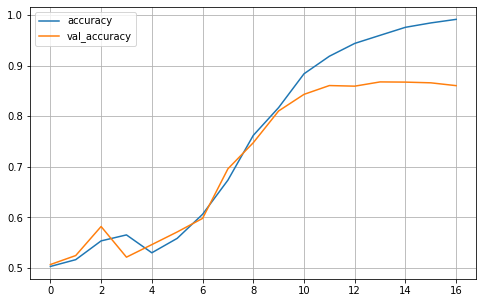

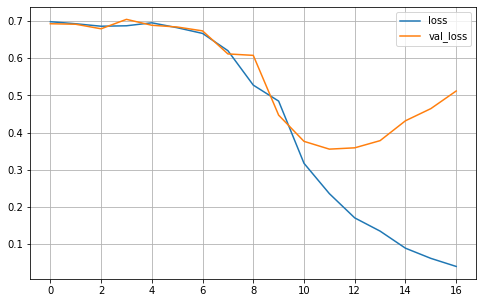

In [87]:
plot_learning_curves(history_bi_rnn_dropout, 'accuracy')
plot_learning_curves(history_bi_rnn_dropout, 'loss')

In [82]:
initializer = keras.initializers.Orthogonal()
bi_lstm_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length,
                           mask_zero=True),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 32, return_sequences = False, kernel_initializer=initializer)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation = 'selu', kernel_initializer=initializer),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_lstm_model.summary()
bi_lstm_model.compile(optimizer = keras.optimizers.Adam(1e-4),
                             loss = 'binary_crossentropy',
                             metrics = ['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                12544     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 174,657
Trainable params: 174,657
Non-trainable params: 0
_______________________________________________

In [83]:
history_bi_lstm = bi_lstm_model.fit(
    train_data, train_labels,
    epochs = 50,
    batch_size = batch_size,
    validation_split = 0.2,
    callbacks = [earlyStop])

Epoch 1/50
20/20 [==============================] - 12s 270ms/step - loss: 0.6930 - accuracy: 0.5058 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/50
20/20 [==============================] - 3s 144ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5076
Epoch 3/50
20/20 [==============================] - 3s 147ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6929 - val_accuracy: 0.5286
Epoch 4/50
20/20 [==============================] - 3s 143ms/step - loss: 0.6928 - accuracy: 0.5262 - val_loss: 0.6927 - val_accuracy: 0.5108
Epoch 5/50
20/20 [==============================] - 3s 144ms/step - loss: 0.6923 - accuracy: 0.5355 - val_loss: 0.6925 - val_accuracy: 0.5122
Epoch 6/50
20/20 [==============================] - 3s 144ms/step - loss: 0.6921 - accuracy: 0.5395 - val_loss: 0.6920 - val_accuracy: 0.5402
Epoch 7/50
20/20 [==============================] - 3s 146ms/step - loss: 0.6916 - accuracy: 0.5617 - val_loss: 0.6913 - val_accuracy: 0.5786
Epoch

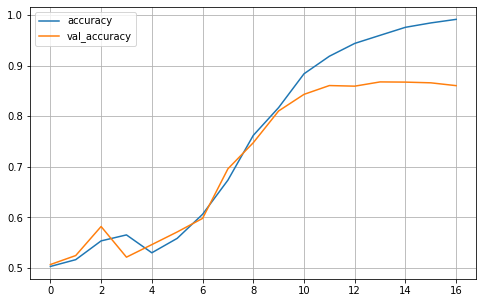

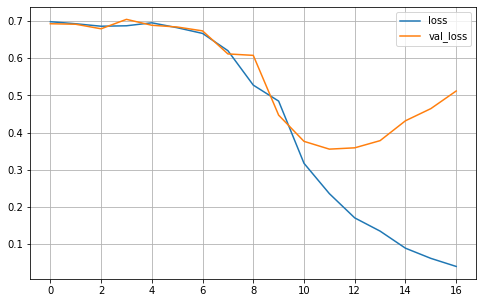

In [86]:
plot_learning_curves(history_bi_rnn_dropout, 'accuracy')
plot_learning_curves(history_bi_rnn_dropout, 'loss')